In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [106]:
# Importing Data

all_data = pd.read_csv("Comtrade_Yearly_95to23.csv")

data = all_data[["Period", "ReporterISO", "ReporterDesc", "MotCode", "MotDesc","QtyUnitAbbr", "NetWgt","IsNetWgtEstimated", "Fobvalue"]]
data.columns = ["Year", "Importer_Code", "Importer_Country","MOT_Code", "MOT_Desc", "Unit", "Weight", "IsWeightEstimated", "FOB_Value"]

data.head()

,Year,Importer_Code,Importer_Country,MOT_Code,MOT_Desc,Unit,Weight,IsWeightEstimated,FOB_Value
0,1995,ARG,Argentina,0,TOTAL MOT,kg,1455875.0,False,546969.0
1,1995,AUS,Australia,0,TOTAL MOT,kg,33753.0,False,20423.0
2,1995,AUT,Austria,0,TOTAL MOT,kg,2210.0,False,2281.0
3,1995,BEL,Belgium-Luxembourg (...1998),0,TOTAL MOT,kg,10942600.0,False,5829923.0
4,1995,BRA,Brazil,0,TOTAL MOT,kg,689750.0,False,451042.0


In [107]:
# To adjust prices with Inflation, we use US CPI
cpi = pd.read_csv("US_CPI.csv")
cpi["CPI"] = (cpi["CPI"] / np.min(cpi["CPI"]))
cpi.head()

,Year,CPI
0,1995,1.000000
1,1996,1.029354
2,1997,1.053231
3,1998,1.069660
4,1999,1.093100


In [108]:
# Only use Total MOT for not to double count
df = data[data["MOT_Code"] == 0]

# Get rid of NAN or 0 entries for weight
df = df[~df['Weight'].isin([np.NaN, 0.0])]

In [109]:
est_ratio = np.sum(df[df['IsWeightEstimated'] == True]['Weight']) / np.sum(df['Weight'])

print( str(round(100 * est_ratio,2)) + "% of the exports are estimation, the rest is accurate.")

15.49% of the exports are estimation, the rest is accurate.


In [110]:
# Calculating Unit Price
df['Unit_Price'] = df['FOB_Value'] / df['Weight']

# Merging CPI with df to calculate real prices
df = pd.merge(left=df, right=cpi, on= "Year")

df["Real_Unit_Price"] = df['Unit_Price'] * df['CPI']

df.tail(5)

,Year,Importer_Code,Importer_Country,MOT_Code,MOT_Desc,Unit,Weight,IsWeightEstimated,FOB_Value,Unit_Price,CPI,Real_Unit_Price
1694,2023,SWE,Sweden,0,TOTAL MOT,kg,25269.726,True,39207.696,1.551568,1.999455,3.102290
1695,2023,CHE,Switzerland,0,TOTAL MOT,kg,35084.808,True,5649.595,0.161027,1.999455,0.321966
1696,2023,TUR,Türkiye,0,TOTAL MOT,kg,208600.000,False,229484.000,1.100115,1.999455,2.199630
1697,2023,GBR,United Kingdom,0,TOTAL MOT,kg,32291.825,True,47445.810,1.469282,1.999455,2.937763
1698,2023,TZA,United Rep. of Tanzania,0,TOTAL MOT,kg,690000.000,False,323949.990,0.469493,1.999455,0.938729


In [111]:
# Calculate total weight per year
df['Total_Weight_Per_Year'] = df.groupby('Year')['Weight'].transform('sum')

# Calculate the weight ratio
df['Weight_Ratio'] = df['Weight'] / df['Total_Weight_Per_Year']

# Calculate the weighted price 
df["Weighted_Real_Unit_Price"] = df['Real_Unit_Price'] * df['Weight_Ratio']

# Calculating average price for each year
Average_Prices = df.groupby('Year', as_index=False)['Weighted_Real_Unit_Price'].sum()


In [112]:
Average_Prices

,Year,Weighted_Real_Unit_Price
0,1995,0.295339
1,1996,0.354848
2,1997,0.373202
3,1998,0.536975
4,1999,0.391777
5,2000,1.127300
6,2001,1.134150
7,2002,1.118096
8,2003,0.909189
9,2004,0.112614


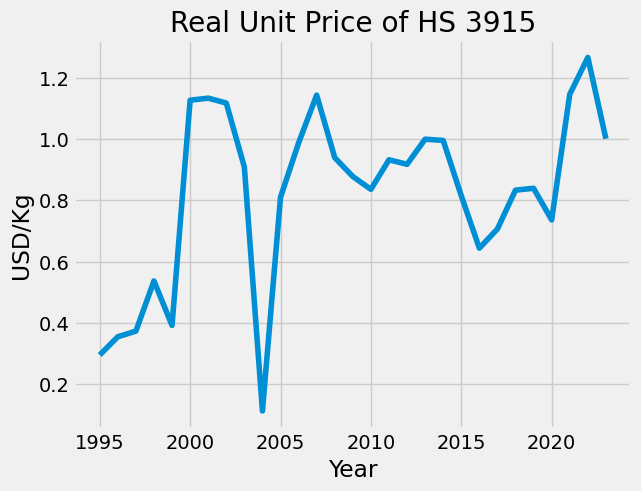

In [120]:
plt.style.use('fivethirtyeight')

plt.plot(Average_Prices['Year'], Average_Prices['Weighted_Real_Unit_Price'])
plt.xlabel("Year")
plt.ylabel("USD/Kg")
plt.title("Real Unit Price of HS 3915")

plt.show()